In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rlutils

In [2]:
'''策略网络Policy Net，同REINFORCE'''
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [3]:
'''AC算法还额外引入了一个价值网络'''
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [4]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_rl, critic_rl, gamma, device) -> None:
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_rl)
        
        # 价值网络
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        # 价值网络优化器
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_rl)

        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dist):
        states = torch.tensor(transition_dist['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dist['actions']).view(-1, 1)
        rewards = torch.tensor(transition_dist['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dist['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dist['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)  # 时序差分误差
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())

        # 均方误差损失函数
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度 
        self.actor_optimizer.step()  # 更新参数
        self.critic_optimizer.step()
        

In [5]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device('cude') if torch.cuda.is_available() else torch.device('cpu')

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

return_list = rlutils.train_on_policy_agent(env, agent, num_episodes)

c:\Users\guimengke\Anaconda\envs\RL\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]c:\Users\guimengke\Anaconda\envs\RL\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  app.launch_new_instance()
Iteration 9: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s, episode=1000, return=477.300]


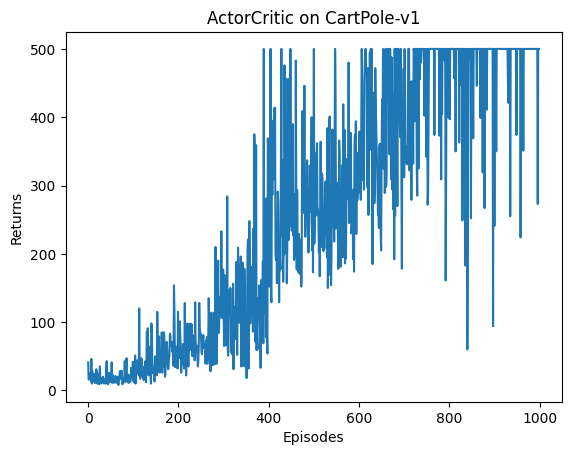

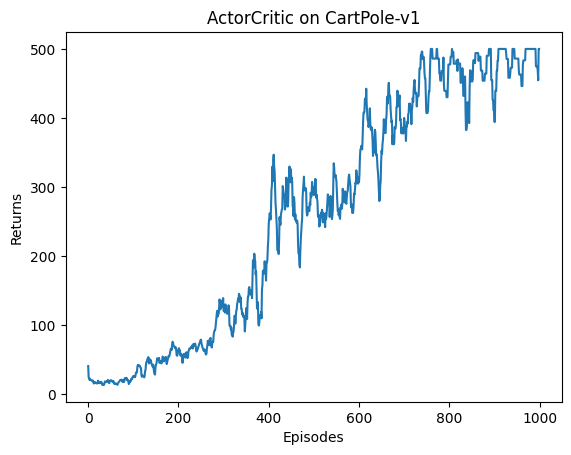

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('ActorCritic on {}'.format(env_name))
plt.show()

mv_return = rlutils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('ActorCritic on {}'.format(env_name))
plt.show()

In [15]:
state = env.reset()
done = False
total_reward = 0
while not done:
    env.render()
    action = agent.take_action(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    total_reward += reward
env.close()
print(total_reward)

500.0
